In [2]:
using PyPlot,Statistics

In [3]:
β_t(t_st::Number,ρ::Number,t_pt::Number,β_0) = ifelse( t_pt < t_st , β_0,β_0*exp(-ρ*(t_pt-t_st)));
function μ_t(D,N;k=3)
    #[end-k:end]
    C12 = mean(D["hk.other.out"][end-k:end]);
    C13 = mean(D["hk.air.out"][end-k:end]);
    C11 = N[1] - C12 - C13;
    
    C21 = mean(D["cn.other.in"][end-k:end]);
    C23 = 0;
    C22 = N[2] - C21 - C23;
    
    C31 = mean(D["cn.air.in"][end-k:end]);
    C32 = 0;
    C33 = N[3] - C31 - C32;
    
    μ = [[C11 C12 C13]./N[1];
         [C21 C22 C23]./N[2];
         [C31 C32 C33]./N[3]];
    return μ
end

μ_t (generic function with 1 method)

## Defining the SEIR Model

In [4]:
#汁 :https://www.overleaf.com/project/5e3821636595130001de8e29
∑_ji(A,j::Int) = sum([ifelse(i==j,0,A[j,i]) for i=1:size(A)[1]]); #Test with some simple

function seir_ode(Y,p,t::Int)
    α,β,γ = p.α[1],p.β[1],p.γ[1] ;
    #println("β = $β")
    μ,θ,σ = p.μ[1],p.θ[1],p.σ[1] ;
    N     = p.N[1];
    S,E,I,R     = Y.S[:,t],Y.E[:,t],Y.I[:,t],Y.R[:,t];
    NCity       = length(N);
    dS,dE,dI,dR = zeros(NCity),zeros(NCity),zeros(NCity),zeros(NCity);
    #print("Finish Part 1")
    for i = 1:NCity
        dS[i] = ( -∑_ji(μ,i).*S[i]    + ∑_ji((μ.*S)',i)    ) - β*I[i]*S[i]/N[i];
        dE[i] = ( -∑_ji(σ.*μ,i).*E[i] + ∑_ji((σ.*μ.*E)',i) ) - α*E[i] + β*I[i]*S[i]/N[i];
        dI[i] = ( -∑_ji(θ.*μ,i).*I[i] + ∑_ji((θ.*μ.*I)',i) ) - γ*I[i] + α*E[i];
        dR[i] = ( -∑_ji(μ,i).*R[i]    + ∑_ji((μ.*R)',i)    ) + γ*I[i];    
    end
    Y.S[:,t+1] = Y.S[:,t] .+ dS;
    Y.E[:,t+1] = Y.E[:,t] .+ dE;
    Y.I[:,t+1] = Y.I[:,t] .+ dI;
    Y.R[:,t+1] = Y.R[:,t] .+ dR;
end

seir_ode (generic function with 1 method)

## Initial Condition

In [5]:
# Declaring The immigration data of HK
# Format: 1D Array -> 2D Array(Size =8*Nt )
# col definition :"hk.air.in", 
#                 "hk.other.in", 
#                 "cn.air.in", 
#                 "cn.other.in",
#                 "hk.air.out",
#                 "hk.other.out",
#                 "cn.air.out", 
#                 "cn.other.out"

Rimmd = [20724, 81939,  9124,  27581, 74876, 219909, 4451, 26889,
        14907, 71510,  8489,  21402, 58711, 127457, 5326, 23462,
        22646, 141022, 10955, 25735, 47580, 73816,  7870, 30430,
        36215, 141255, 10309, 18471, 41316, 49161,  8203, 26500,
        54491, 134297, 7187,  16969, 41100, 40804,  8306, 21240,
        50292, 147280, 9196,  18584, 33880, 42766,  7550, 25235,
        46214, 86292,  9907,  9648,  31072, 37007,  7122, 17706,
        49093, 67451,  7817,  8241,  28231, 39275,  5737, 13257,
        55976, 59146,  5703,  7679,  28798, 37049,  5072, 10327,
        59083, 63316,  4649,  7066,  25570, 31771,  4360, 10025,
        41208, 69825,  6996,  6465,  21704, 41031,  3596, 11650,
        31173, 23643,  6317,  3194,  20187, 14218,  3550, 7726];
Nt   = div(length(Rimmd),8);   #Getting the number of days to reshape the 1D array
Rimmd = reshape(Rimmd,(8,Nt)); #Turning the 1D array to 2D array
immd = Dict("hk.air.in"    => Rimmd[1,:],
            "hk.other.in"  => Rimmd[2,:],
            "cn.air.in"    => Rimmd[3,:],
            "cn.other.in"  => Rimmd[4,:],
            "hk.air.out"   => Rimmd[5,:],
            "hk.other.out" => Rimmd[6,:],
            "cn.air.out"   => Rimmd[7,:],
            "cn.other.out" => Rimmd[8,:]);

In [6]:
#Define the data struct for latter use
struct SEIR_Y #Need to change
    S
    E
    I
    R
end

struct parameter
    θ
    σ
    μ
    α
    β
    γ
    N
end

In [7]:
#Setting of Initial Condition 
N_t0 = [7392000, 1302.66*10^5, 1265148000];
E_t0 = [100, 1e4, 1e5];
I_t0 = [20, 725, 5404];
R_t0 = [0,21, 200];
S_t0 = N_t0 - E_t0 - I_t0 - R_t0;
R0     = 2.5;
α,γ    = 1/6.1,1/7.5;
β      = R0*γ;
Nt     = 100;
# Parameter for β(t)
t_st = 10;
ρ    = 0.1;

In [8]:
#Fix Mu approach
C12 = 1e4;
C13 = 1e4;
C21 = 1e4;
C23 = 1e5;
C31 = 1e4;
C32 = 1e5;
C11 = N_t0[1] - C12 - C13;
C22 = N_t0[2] - C21 - C23;
C33 = N_t0[3] - C31 - C32;
μ = [[C11 C12 C13]./N_t0[1];
     [C21 C22 C23]./N_t0[2];
     [C31 C32 C33]./N_t0[3]];

In [12]:
#Value initialization 
NCity   = size(N_t0)[1];
S,E,I,R = zeros(Float64,NCity,Nt),zeros(Float64,NCity,Nt),
          zeros(Float64,NCity,Nt),zeros(Float64,NCity,Nt);
S[:,1] =  S_t0;
E[:,1] =  E_t0;
I[:,1] =  I_t0;
R[:,1] =  R_t0;

#Parameter initializatio
#μ  = μ_t(immd,N_t0);
θ  = fill(0,size(μ));
σ  = zeros(size(μ));
#Put it in data struct
Y     = SEIR_Y(S,E,I,R);
parms = parameter([θ],[σ],[μ],[α],[β],[γ],[N_t0]);

In [10]:
function plotSIR(Y)
    ax = subplot(221)
    plot(Y.S[1,:],label="S")
    legend()
    ylabel("Numbers of ppl",fontsize=15);ax.set_xticks([])
    ax = subplot(222)
    plot(Y.E[1,:],label="E");ax.set_xticks([])
    legend()
    ax = subplot(223)
    plot(Y.I[1,:],label="I")
    legend()
    xlabel("Days",fontsize=15)
    ylabel("Numbers of ppl",fontsize=15)
    ax = subplot(224)
    plot(Y.R[1,:],label="R")
    legend()
    xlabel("Days",fontsize=15)
    subplots_adjust(wspace=0.2, hspace=0.0)
end

plotSIR (generic function with 1 method)

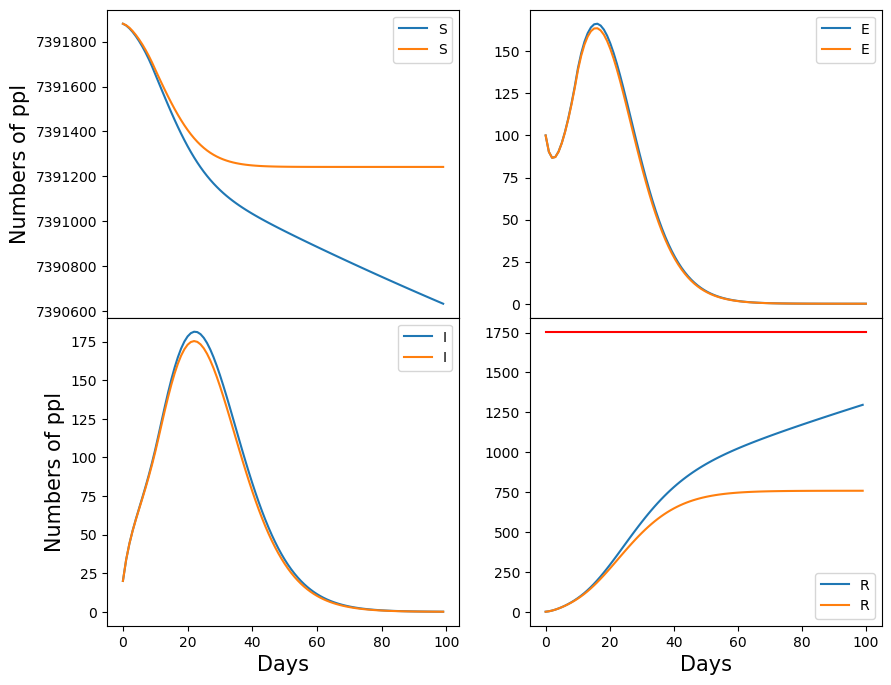

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f0080306630>

In [11]:
figure(figsize=(10,8))
μ = [[C11 C12 C13]./N_t0[1];
     [C21 C22 C23]./N_t0[2];
     [C31 C32 C33]./N_t0[3]];
parms = parameter([θ],[σ],[μ],[α],[β],[γ],[N_t0]);
for t = 1:Nt-1
    parms.β[1] = β_t(t_st,ρ,t,β);
    seir_ode(Y,parms,t)
end
plotSIR(Y)
#I am using \sigma  \theta = 0.3 in this case
parms.μ[1].=0
for t = 1:Nt-1
    parms.β[1] = β_t(t_st,ρ,t,β);
    seir_ode(Y,parms,t)
end
plotSIR(Y)
subplot(224);plot([0,Nt],[1755,1755],"r") #SARS comparsion